In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from matplotlib.ticker import FuncFormatter

In [61]:
types = ["sinks", "sources", "workers"]
hatches = {
    "nemo": "///",  # Triple diagonal lines
    "bottom_up": "+++",  # Triple plus signs
    "top_down": "xxx",  # Triple 'x' marks
    "mst": "ooo",  # Triple circles
    "chain": "///+++xxx"  # Combination of patterns
}


def format_func(value, tick_number):
    k_value = int(value) // 1000
    if k_value == 0:
        return f"{value:.0f}"
    elif k_value == 1:
        return f"{k_value}k"
    else:
        return f"{k_value:,}k"


def plot_bar_for_type(ax, df, type, val_col, ylabel, plot_order=None, title=True, show_text=True):
    df = df.groupby(['approach', 'type', 'node_id'])[val_col].max().reset_index()
    df = df.groupby(['approach', 'type'])[val_col].mean().reset_index()
    df = df[df['type'] == type]

    if plot_order is None:
        plot_order = df["approach"].tolist()

    for app in plot_order:
        val = df[df['approach'] == app][val_col].tolist()[0]  # Extract the single value
        ax.bar(app, val, color="black", hatch=hatches[app])
        if show_text:
            ax.text(app, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

    if show_text:
        # Calculate the maximum y-axis value
        max_y = ax.get_ylim()[1]
        # Set y-axis limit slightly higher to make space for labels
        ax.set_ylim(0, max_y * 1.4)

    # set title
    if type == "workers":
        type = "cluster heads"
    if title:
        ax.set_title(type)
    ax.set_ylabel(ylabel)

    # Apply the formatting function to the y-axis using FuncFormatter
    formatter = FuncFormatter(format_func)
    ax.yaxis.set_major_formatter(formatter)
    return ax


def convert_bytes_to_megabytes(df, columns):
    for col in columns:
        df[col] = df[col] / (1024 ** 2)  # convert from bytes to megabytes
    return df


def get_type(node_id):
    type = "invalid"
    node_id = int(node_id)
    if node_id in coordinator:
        type = "sinks"
    elif node_id in workers:
        type = "workers"
    elif node_id in sensors:
        type = "sources"
    return type

In [62]:
root_dir = "datasets/NES/311023/monitoring/"

directory_dict = {
    "chain": "bottomUpWithMonitoringSourceChain",
    # "chain_stress": "bottomUpWithMonitoringSourceChain_stressed",
    "mst": "bottomUpWithMonitoringSourceMst",
    # "mst_stress": "bottomUpWithMonitoringSourceMst_stressed",
    "top_down": "topDownWithMonitoringSourceThreeLevel",
    # "top_down_stress": "topDownWithMonitoringSourceThreeLevel_stressed",
    "bottom_up": "bottomUpWithMonitoringSourceThreeLevel",
    # "bottom_up_stress": "bottomUpWithMonitoringSourceThreeLevel_stressed",
    "nemo": "nemoPlacementWithMonitoringSourceThreeLevel",
    # "nemo_stress": "nemoPlacementWithMonitoringSourceThreeLevel_stressed"
}

core_cols = ["time (s)", "node_id", "approach", "type"]
columns = {
    "cpu": ["cpu_user", "cpu_nice", "cpu_system"],
    "net": ["R_BYTES", "R_PACKETS", "T_BYTES", "T_PACKETS"]
}


In [53]:
coordinator = [1]
sensors = [3, 4, 5, 6, 8, 9, 10, 11]
workers = [2, 7]

df_dict = {}
rows = []
metric = "cpu"

for approach, directory in directory_dict.items():
    fname = root_dir + directory + "/cpu_measurements.txt"
    file = open(fname, 'r')
    lines = file.readlines()
    print("Reading lines for", fname)
    for line in lines:
        sline = line.split(",", 1)
        timestamp = sline[0]
        dictionary_str = sline[1]
        dictionary = ast.literal_eval(dictionary_str)
        for node_id, metrics_dict in dictionary.items():
            type = get_type(node_id)
            row = [float(timestamp), node_id, approach, type, float(metrics_dict["cpu_user"]),
                   float(metrics_dict["cpu_nice"]), float(metrics_dict["cpu_system"])]
            rows.append(row)

df = pd.DataFrame(rows, columns=core_cols + columns[metric])
# important pre-processing to remove the min values
for col in columns[metric]:
    df[col] = df.groupby(['node_id', 'approach'])[col].transform(lambda x: x - x.min())
df_dict[metric] = df

Reading lines for datasets/NES/311023/monitoring/bottomUpWithMonitoringSourceChain/cpu_measurements.txt
Reading lines for datasets/NES/311023/monitoring/bottomUpWithMonitoringSourceMst/cpu_measurements.txt
Reading lines for datasets/NES/311023/monitoring/topDownWithMonitoringSourceThreeLevel/cpu_measurements.txt
Reading lines for datasets/NES/311023/monitoring/bottomUpWithMonitoringSourceThreeLevel/cpu_measurements.txt
Reading lines for datasets/NES/311023/monitoring/nemoPlacementWithMonitoringSourceThreeLevel/cpu_measurements.txt


In [54]:
df_dict["cpu"]

,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system
0,1.698339e+09,1,chain,sinks,0.0,0.0,0.0
1,1.698339e+09,2,chain,workers,0.0,0.0,0.0
2,1.698339e+09,3,chain,sources,0.0,0.0,0.0
3,1.698339e+09,4,chain,sources,0.0,0.0,0.0
4,1.698339e+09,5,chain,sources,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9433,1.698323e+09,7,nemo,workers,3795.0,0.0,538.0
9434,1.698323e+09,8,nemo,sources,6040.0,0.0,709.0
9435,1.698323e+09,9,nemo,sources,5902.0,0.0,614.0
9436,1.698323e+09,10,nemo,sources,5825.0,0.0,676.0


## CPU Utilization

In [63]:
# Create and store the svg files
df = df_dict["cpu"]
df

,time (s),node_id,approach,type,cpu_user,cpu_nice,cpu_system
0,1.698339e+09,1,chain,sinks,0.0,0.0,0.0
1,1.698339e+09,2,chain,workers,0.0,0.0,0.0
2,1.698339e+09,3,chain,sources,0.0,0.0,0.0
3,1.698339e+09,4,chain,sources,0.0,0.0,0.0
4,1.698339e+09,5,chain,sources,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9433,1.698323e+09,7,nemo,workers,3795.0,0.0,538.0
9434,1.698323e+09,8,nemo,sources,6040.0,0.0,709.0
9435,1.698323e+09,9,nemo,sources,5902.0,0.0,614.0
9436,1.698323e+09,10,nemo,sources,5825.0,0.0,676.0


saving plots/NES/sinks_cpu_user.svg
saving plots/NES/sources_cpu_user.svg
saving plots/NES/workers_cpu_user.svg


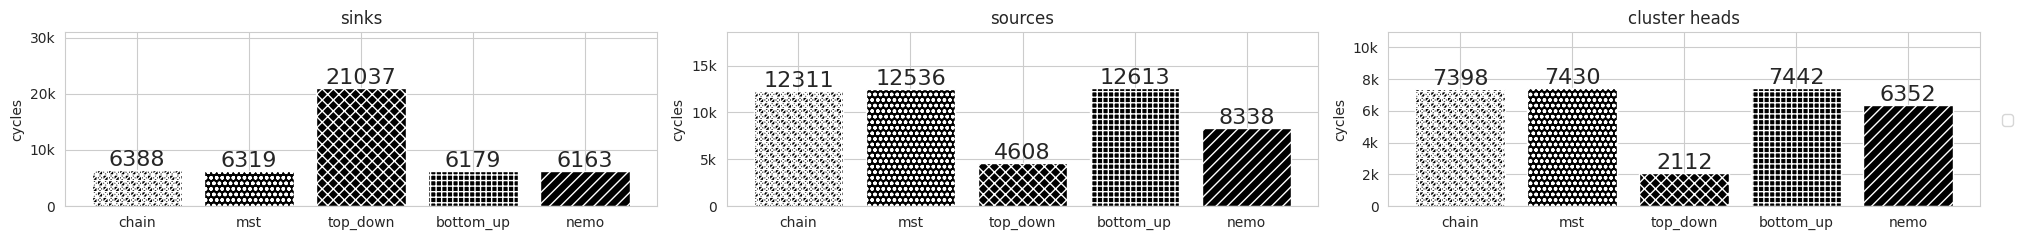

In [64]:
plot_col = "cpu_user"

for i, type in enumerate(types):
    # Create a new figure for each subplot
    fig, ax = plt.subplots(figsize=(8, 2))
    ax = plot_bar_for_type(ax, df, type, plot_col, "cycles", plot_order=directory_dict.keys(), title=False)

    #ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='x', labelsize=20)

    fig.tight_layout()
    filename = os.path.join("plots/NES/", f"{type + '_' + plot_col}.svg")
    print("saving", filename)
    fig.savefig(filename)

    # Close the figure to free up memory
    plt.close(fig)

# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=len(types), figsize=(20, 2.5))
for i, type in enumerate(types):
    axs[i] = plot_bar_for_type(axs[i], df, type, "cpu_user", "cycles", plot_order=directory_dict.keys())

# Create the legend outside the loop
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

# Show the plot
plt.show()

## Produced Buffers

In [65]:
buf_dict = {}
for approach, directory in directory_dict.items():
    if approach.endswith("stress"):
        continue

    fname = root_dir + directory + "/number_of_buffers_query_1.txt"
    df = pd.read_csv(fname, names=["timestamp", "buffers"])
    buf_dict[approach] = df

buf_dict.keys()

dict_keys(['chain', 'mst', 'top_down', 'bottom_up', 'nemo'])

In [66]:
buf_dict["bottom_up"]

,timestamp,buffers
0,1.698316e+09,0
1,1.698316e+09,0
2,1.698316e+09,0
3,1.698316e+09,0
4,1.698316e+09,0
...,...,...
172,1.698316e+09,0
173,1.698316e+09,0
174,1.698316e+09,0
175,1.698316e+09,0


chain 0
mst 0
top_down 9450
bottom_up 0
nemo 0


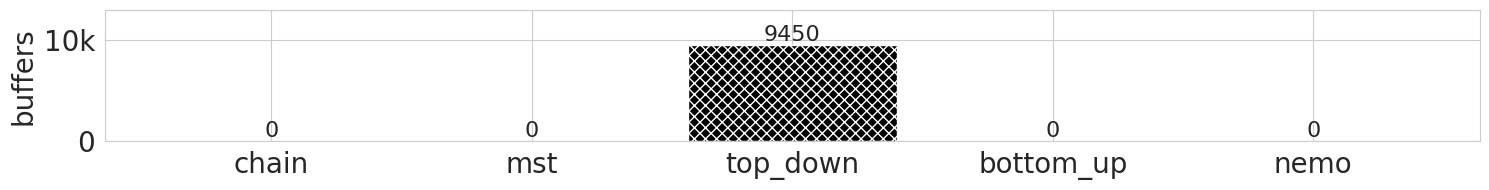

In [70]:
fig, ax = plt.subplots(figsize=(15, 2))
key_order = directory_dict.keys()

for k in key_order:
    df = buf_dict[k]
    val = df["buffers"].max()
    print(k, val)
    ax.bar(k, val, hatch=hatches[k], color="black")
    ax.text(k, val, f"{val:.0f}", ha='center', va='bottom', fontsize=16)

# Calculate the maximum y-axis value
max_y = ax.get_ylim()[1]
# Set y-axis limit slightly higher to make space for labels
ax.set_ylim(0, max_y * 1.3)

plt.ylabel("buffers", fontsize=20)
plt.tick_params(axis='both', labelsize=20)

formatter = FuncFormatter(format_func)
ax.yaxis.set_major_formatter(formatter)

fig.tight_layout()

plt.savefig("plots/NES/buffers" + ".svg")
plt.show()